In [1]:
import pandas as pd
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
import scipy.fftpack
from datetime import timedelta
import datetime
from scipy import stats

import matplotlib as mpl
from pylab import cm

sns.set(rc={'figure.figsize':(11,4)})

JAIPUR_DIST_ID = 508

In [2]:
time_df = utils.mergeCsvsInDirectory('data/DailyAverages')
jaipur_df = time_df[time_df['unique_dist_id'] == JAIPUR_DIST_ID]
jaipur_annual_df = jaipur_df.groupby(by=['month', 'day']).mean().drop(columns=['year', 'unique_dist_id']).reset_index()

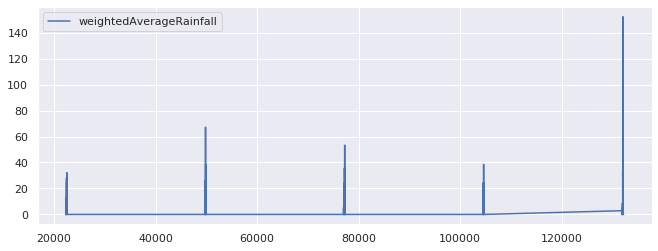

In [3]:
jaipur_df.plot(y='weightedAverageRainfall')

In [4]:
jaipur_annual_df['date'] = jaipur_annual_df['month'].astype(str) + '-' + jaipur_annual_df['day'] .astype(str) + '-' + '2012'
jaipur_annual_df['date'] = pd.to_datetime(jaipur_annual_df['date'])
jaipur_annual_df = jaipur_annual_df.set_index('date')

rainfall_outliers = np.abs(stats.zscore(jaipur_annual_df['weightedAverageRainfall'])) > 3
temperature_outliers = np.abs(stats.zscore(jaipur_annual_df['weightedAverageTemperature'])) > 3

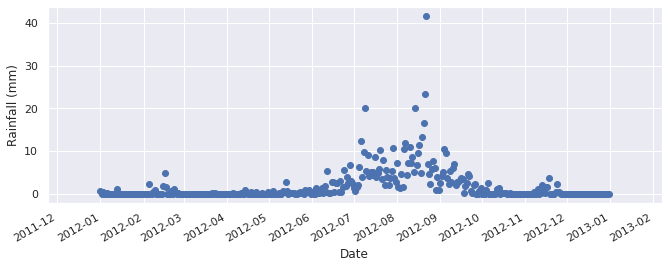

In [5]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month

fig, ax = plt.subplots()

ax.scatter(jaipur_annual_df.index, jaipur_annual_df.loc['2012', "weightedAverageRainfall"])
ax.set_xlabel('Date');
ax.set_ylabel('Rainfall (mm)');

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_minor_locator(months)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

The monsoon traditionally starts around June and ends in September, so we can use that as a heuristic for which time to search in. Then, we can look for a moment in that period with strong curvature.

In [6]:
smoothed_rainfall = jaipur_annual_df['weightedAverageRainfall'].rolling(30, win_type='gaussian').mean(std=5)
inflections = smoothed_rainfall.diff(1)
curvature = inflections.diff(1)

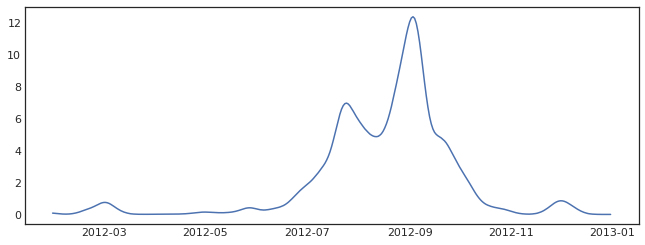

In [14]:
plt.plot(smoothed_rainfall)

In [7]:
start = curvature['2012-4':'2012-6'].idxmax()
end = curvature['2012-9':'2012-11'].idxmax()

In [8]:
print(f'start: {start}')
print(f'end: {end}')

start: 2012-06-21 00:00:00
end: 2012-09-14 00:00:00


In [10]:
import matplotlib.font_manager as fm
import matplotlib.dates as dates
import matplotlib.ticker as ticker

plt.style.use('seaborn-white')


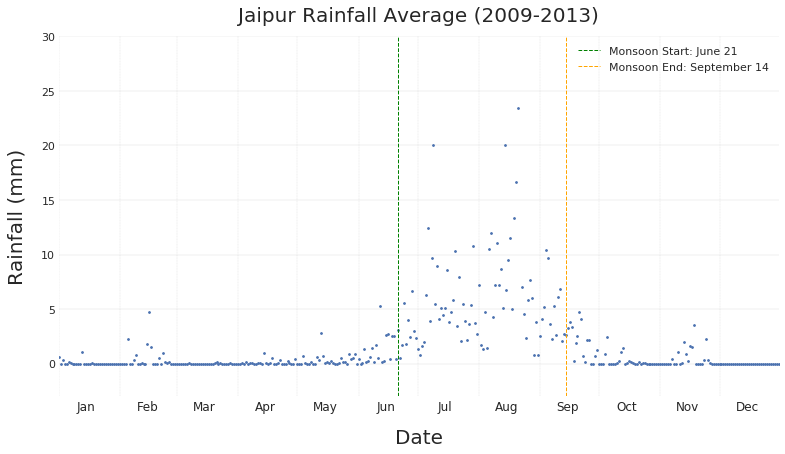

In [11]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
plt.title('Jaipur Rainfall Average (2009-2013)', fontsize=20, pad=15)

ax.scatter(
    jaipur_annual_df.index, 
    jaipur_annual_df.loc['2012', "weightedAverageRainfall"],
    marker='o',
#     c='blue',
    s=3
    
)

ax.set_xlim([datetime.date(2012, 1, 1), datetime.date(2012, 12, 31)])
ax.set_ylim([-3, 30])

ax.set_xlabel('Date', fontsize=20, labelpad=15);
ax.set_ylabel('Rainfall (mm)', fontsize=20, labelpad=15);

# format the ticks
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))
ax.tick_params(axis='both', which='minor', labelsize=12)

ax.xaxis.grid(linestyle='dashed', linewidth=.3)
ax.yaxis.grid(linestyle='-', linewidth=.3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

start_date = start.strftime('%b %d')
end_date = end.strftime('%b %d')

startLine = plt.axvline(x=start, c='green', lw=1, ls='--')
endLine = plt.axvline(x=end, c='orange', lw=1, ls='--')

plt.legend([startLine, endLine], ['Monsoon Start: June 21', 'Monsoon End: September 14'])
plt.savefig('./graph.pdf', dpi=300, transparent=False, bbox_inches='tight')

With more time, I would use a Fourier transform to determine the periodicity of the monsoon over the years.